In [1]:
!pip install  librosa

# !하면 shell 명령어

    100% |################################| 1.5MB 778kB/s eta 0:00:01
    100% |################################| 327kB 4.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/7a/bf/9f/fc279e1814da2144161848a7419cdcf923d0c03f481abe7904
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/47/cc/d8/e1476000d1720a72117ef5c0b1a51388b8567ebfface47ede7
  Running setup.py bdist_wheel for resampy ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/c6/8e/c0/4c402972789ddf6d2d701468417de19d0cad28bd698a867e2d
Successfully built librosa audioread resampy


In [2]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

#librosa 사운드 받아드리는 패키지 
#from matplotlib.pyplot import specgram
#from sklearn.metrics import precision_recall_fscore_support


plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    files = []
    print('==DIR', parent_dir)
    for label, sub_dir in enumerate(sub_dirs):
        print('====DIR', label, sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            basename = os.path.basename(fn)
            try:
                mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
                ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
                features = np.vstack([features,ext_features])
                label = basename.split('-')[1]
                labels = np.append(labels, label)
                files.append(basename)
                print(fn, label, ext_features.shape)
            except:
                print(fn, 'SKIP')
            
            
    return files, np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = 10 # len(np.unique(labels))
    one_hot = np.zeros((n_labels,n_unique_labels))
    one_hot[np.arange(n_labels), labels] = 1
    return one_hot

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
parent_dir = 'audio'

sub_dirs = ['data']
files, features, labels = parse_audio_files(parent_dir,sub_dirs)
print('Audio Data Loading Done')
print("feature. shape",features.shape)
print("label. shape",labels.shape)


labels = one_hot_encode(labels)
for f, l in zip(files, labels):
    print(f, l)


train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

training_epochs = 5000
n_dim = features.shape[1]
print('DIM', n_dim)
n_classes = 10
#n_hidden_units_one = 280 
#n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01


n_hidden_units_one = 300
n_hidden_units_two = 200
n_hidden_units_three = 100

## None는 학습할 데이터의 숫자가 정해지지 않아서 
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim, n_hidden_units_one], mean=0, stddev=sd), name="w1")
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean=0, stddev=sd), name="b1")
h_1 = tf.nn.sigmoid(tf.matmul(X, W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one, n_hidden_units_two], mean=0, stddev=sd), name="w2")
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean=0, stddev=sd), name="b2")
h_2 = tf.nn.tanh(tf.matmul(h_1, W_2) + b_2)

W_3 = tf.Variable(tf.random_normal([n_hidden_units_two, n_hidden_units_three], mean=0, stddev=sd), name="w3")
b_3 = tf.Variable(tf.random_normal([n_hidden_units_three], mean=0, stddev=sd), name="b3")
h_3 = tf.nn.sigmoid(tf.matmul(h_2, W_3) + b_3)

W = tf.Variable(tf.random_normal([n_hidden_units_three, n_classes], mean=0, stddev=sd), name="w")
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd), name="b")
y_ = tf.nn.softmax(tf.matmul(h_3, W) + b)

==DIR audio
====DIR 0 data
audio/data/138031-2-0-2.wav 2 (193,)
audio/data/87275-1-5-0.wav 1 (193,)
audio/data/19026-1-0-0.wav 1 (193,)
audio/data/87275-1-3-0.wav SKIP


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/librosa/util/utils.py:1632: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0) or np.any(X_ref < 0):
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/librosa/util/utils.py:1645: RuntimeWarning: invalid value encountered in less
  bad_idx = (Z < np.finfo(dtype).tiny)


audio/data/72261-3-0-6.wav 3 (193,)
audio/data/15564-2-0-1.wav 2 (193,)
audio/data/31840-3-0-0.wav 3 (193,)
audio/data/102106-3-0-0.wav 3 (193,)
audio/data/105415-2-0-4.wav 2 (193,)
audio/data/24074-1-0-2.wav 1 (193,)
audio/data/105415-2-0-6.wav 2 (193,)
audio/data/24074-1-0-9.wav 1 (193,)
audio/data/24074-1-0-6.wav 1 (193,)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


audio/data/9031-3-1-0.wav 3 (193,)
audio/data/9031-3-2-0.wav 3 (193,)
audio/data/105415-2-0-1.wav 2 (193,)
audio/data/72579-3-0-3.wav 3 (193,)
audio/data/87275-1-1-0.wav SKIP
audio/data/15564-2-0-2.wav 2 (193,)
audio/data/101415-3-0-3.wav 3 (193,)
audio/data/87275-1-4-0.wav 1 (193,)
audio/data/94868-1-1-0.wav 1 (193,)
audio/data/24074-1-0-0.wav 1 (193,)
audio/data/24074-1-0-10.wav 1 (193,)
audio/data/54858-3-0-0.wav 3 (193,)
audio/data/31840-3-1-0.wav 3 (193,)
audio/data/24074-1-0-3.wav 1 (193,)
audio/data/72579-3-0-0.wav 3 (193,)
audio/data/94868-1-2-0.wav 1 (193,)
audio/data/72579-3-0-4.wav 3 (193,)
audio/data/51022-3-7-0.wav 3 (193,)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


audio/data/9031-3-3-0.wav 3 (193,)
audio/data/43786-3-0-0.wav 3 (193,)
audio/data/7383-3-1-0.wav 3 (193,)
audio/data/138031-2-0-7.wav 2 (193,)
audio/data/97317-2-0-5.wav 2 (193,)
audio/data/87275-1-2-0.wav 1 (193,)
audio/data/65749-3-1-9.wav 3 (193,)
audio/data/24074-1-0-1.wav 1 (193,)
audio/data/24074-1-0-7.wav 1 (193,)
audio/data/24074-1-0-5.wav 1 (193,)
audio/data/7383-3-0-0.wav 3 (193,)
audio/data/72579-3-0-2.wav 3 (193,)
audio/data/101415-3-0-2.wav 3 (193,)
audio/data/24074-1-0-4.wav 1 (193,)
audio/data/94868-1-0-0.wav 1 (193,)
audio/data/108362-2-0-9.wav 2 (193,)
audio/data/31323-3-0-1.wav 3 (193,)
audio/data/43786-3-1-0.wav 3 (193,)
audio/data/87275-1-0-0.wav 1 (193,)
audio/data/31323-3-0-2.wav 3 (193,)
audio/data/54858-3-2-0.wav 3 (193,)
audio/data/7383-3-0-1.wav 3 (193,)
audio/data/105415-2-0-8.wav 2 (193,)
audio/data/15564-2-0-0.wav 2 (193,)
audio/data/108362-2-0-7.wav 2 (193,)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


audio/data/9031-3-4-0.wav 3 (193,)
audio/data/24074-1-0-8.wav 1 (193,)
audio/data/101415-3-0-8.wav 3 (193,)
audio/data/54858-3-1-2.wav 3 (193,)
Audio Data Loading Done
feature. shape (58, 193)
label. shape (58,)
138031-2-0-2.wav [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
87275-1-5-0.wav [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
19026-1-0-0.wav [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
72261-3-0-6.wav [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
15564-2-0-1.wav [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
31840-3-0-0.wav [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
102106-3-0-0.wav [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
105415-2-0-4.wav [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
24074-1-0-2.wav [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
105415-2-0-6.wav [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
24074-1-0-9.wav [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
24074-1-0-6.wav [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
9031-3-1-0.wav [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
9031-3-2-0.wav [ 0.  0.  0.  1.

In [5]:
init = tf.global_variables_initializer()

cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)


correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

In [9]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        if epoch % 100 == 0:
            print(cost)
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    print("y_pred,,,",y_pred.shape)
    print("y_true,,,",y_true.shape)
    print("y_pred>>",y_pred)
    print("y_true>>", y_true)
    saver = tf.train.Saver()
    save_path = saver.save(sess, "./sound_trained.ckpt")
    print("Model saved in file: %s" % save_path)

    

2.31917
0.944443
0.734608
0.532519
0.37978
0.277412
0.20721
0.160121
0.127604
0.104698
0.0873547
0.0737614
0.0628431
0.053781
0.0464999
0.0405112
0.0355488
0.0314079
0.0279153
0.024756
0.02209
0.0198194
0.0179908
0.0164217
0.0151087
0.0139692
0.0129681
0.0120681
0.0112645
0.0105639
0.0099359
0.00937019
0.00885697
0.00831449
0.00789293
0.00751214
0.00716161
0.00683672
0.00653293
0.00624767
0.00598241
0.00573899
0.00551594
0.00531027
0.00511956
0.0049418
0.00477551
0.00461949
0.00447277
0.00433452
y_pred,,, (17,)
y_true,,, (17,)
y_pred>> [3 1 3 3 2 2 1 1 3 1 3 1 3 2 2 2 3]
y_true>> [2 1 3 3 2 1 1 1 3 1 3 1 3 2 2 2 3]
Model saved in file: ./sound_trained.ckpt


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


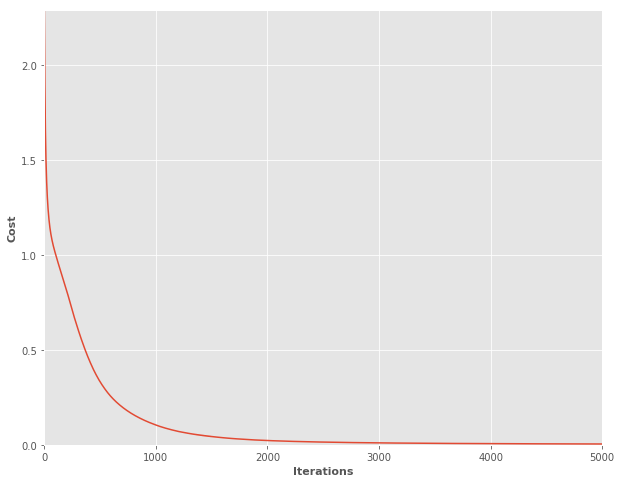

In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

#p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
#print("F-Score:", round(f,3))